In [13]:
# %% [markdown]
# # Sentiment-Based Return Prediction: Deliverable #2
#
# This notebook presents our approach to forecast next-day stock returns using Reddit sentiment data.
#
# We first perform extensive feature engineering on the raw sentiment data, then build a predictive model using
# a regularized linear regression (Ridge) with time-series validation, and finally implement standardized prediction functions.
#

# %% [code]
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import scipy.stats as stats

# For preprocessing and modeling
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit

# For demonstration purposes, load training files (assume CSV files are in the same directory)
returns_df = pd.read_csv('return_train_2017_2021.csv')
reddit_df = pd.read_csv('sentiment_train_2017_2021.csv')

print("Reddit data shape:", reddit_df.shape)
print("Returns data shape:", returns_df.shape)
print("Reddit columns:", reddit_df.columns.tolist())
print("Returns columns:", returns_df.columns.tolist())


Reddit data shape: (11929999, 21)
Returns data shape: (2459589, 5)
Reddit columns: ['StoryID', 'Post_Time', 'Received_Time', 'Ticker', 'Country', 'ISIN', 'Relevance', 'Sentiment', 'Confidence', 'Prob_POS', 'Prob_NTR', 'Prob_NEG', 'Reddit_Topic', 'TopicWeight', 'Alex_Topic', 'Source', 'SourceWeight', 'LinkID', 'Author', 'Novelty', 'Comment_Count']
Returns columns: ['Date', 'Ticker', 'D0', 'D1', 'Return']


In [14]:
# %% [code]
# Convert 'Received_Time' to datetime, localize to UTC, then convert to Eastern Time.
reddit_df['Received_Time'] = pd.to_datetime(reddit_df['Received_Time'])
reddit_df['Received_Time'] = reddit_df['Received_Time'].dt.tz_localize('UTC').dt.tz_convert('America/New_York')

# Create an 'Effective_Date' column: for posts at or after 4 PM ET, shift the date to the next day.
reddit_df['Effective_Date'] = reddit_df['Received_Time'].dt.date
after_4pm = reddit_df['Received_Time'].dt.hour >= 16
reddit_df.loc[after_4pm, 'Effective_Date'] = reddit_df.loc[after_4pm, 'Received_Time'].dt.date + pd.Timedelta(days=1)
reddit_df['Effective_Date'] = pd.to_datetime(reddit_df['Effective_Date'])


In [15]:
# %% [markdown]
# ### Feature Engineering
#
# The helper function below aggregates the raw sentiment data by ticker and day and then computes several features:
#
# 1. **Daily_Sentiment:** Mean sentiment of the day.
# 2. **Sentiment_Std:** Standard deviation of sentiment.
# 3. **Sentiment_Skew:** Skewness of the sentiment distribution.
# 4. **Post_Count:** Total number of posts.
# 5. **Log_Post_Count:** Log-transformed post count.
# 6. **Unique_Author_Count:** Number of unique authors discussing the ticker.
# 7. **Rolling_Avg_3D & Rolling_Avg_7D:** Three-day and seven-day rolling averages of the daily sentiment.
#
# If probability fields such as `Prob_POS` or `Prob_NEG` exist in the data, you can extend this function to incorporate them.


In [16]:
# %% [code]
def create_features(df, rolling_windows=[3, 7], historical_df=None):
    """
    Create aggregated sentiment features for each ticker and day.
    
    Parameters
    ----------
    df : DataFrame
        Daily sentiment data with columns ['Ticker', 'Effective_Date', 'Sentiment'] and optionally 'Author'
    rolling_windows : list of ints
        Windows for rolling average computations.
    historical_df : DataFrame or None
        Optional historical data to compute rolling features if df covers a single day only.
    
    Returns
    -------
    features_df : DataFrame
        Aggregated feature DataFrame with one row per ticker per day.
    """
    # Define the aggregation functions.
    agg_funcs = {
        'Sentiment': ['mean', 'std', lambda x: stats.skew(x)],
        'Ticker': 'count'  # Use count of rows as post count.
    }
    if 'Author' in df.columns:
        agg_funcs['Author'] = lambda x: x.nunique()
    
    # Groupby and aggregate.
    daily_agg = df.groupby(['Ticker', 'Effective_Date']).agg(agg_funcs)
    
    # Reset column names based on whether 'Author' is available.
    if 'Author' in df.columns:
        daily_agg.columns = ['Daily_Sentiment', 'Sentiment_Std', 'Sentiment_Skew', 'Post_Count', 'Unique_Author_Count']
    else:
        daily_agg.columns = ['Daily_Sentiment', 'Sentiment_Std', 'Sentiment_Skew', 'Post_Count']
    
    daily_agg = daily_agg.reset_index()
    
    # Add a log-transformed post count.
    daily_agg['Log_Post_Count'] = np.log(daily_agg['Post_Count'] + 1)
    
    # Sort for rolling calculations.
    daily_agg = daily_agg.sort_values(by=['Ticker', 'Effective_Date'])
    
    # Compute rolling averages for each ticker using all available history.
    for window in rolling_windows:
        col_name = f'Rolling_Avg_{window}D'
        daily_agg[col_name] = daily_agg.groupby('Ticker')['Daily_Sentiment'].transform(lambda x: x.rolling(window, min_periods=1).mean())
    
    return daily_agg


# Create features using the full reddit_df
features_df = create_features(reddit_df)


C:\Users\Lukea\AppData\Local\Temp\ipykernel_32280\1528317376.py:22: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'Sentiment': ['mean', 'std', lambda x: stats.skew(x)],


In [17]:
# %% [markdown]
# ### Merge with Return Data
#
# Next, we merge our aggregated sentiment features with next-day stock returns.


In [26]:
# %% [code]
# Preprocess returns_df
returns_df['Date'] = pd.to_datetime(returns_df['Date'])
if returns_df['Return'].dtype == object:
    returns_df['Return'] = returns_df['Return'].str.rstrip('%').astype('float') / 100
returns_df.dropna(inplace=True)
# Create a signal date (returns data aligned for prediction) 
returns_df['Signal_Date'] = returns_df['Date'] - pd.Timedelta(days=1)
# Rename the "Date" column to avoid duplicate key issues later
returns_df.rename(columns={'Date': 'Return_Date'}, inplace=True)

# Merge features_df with returns_df on Ticker and the appropriate date columns
merged_df = pd.merge(
    features_df, 
    returns_df, 
    left_on=['Ticker', 'Effective_Date'], 
    right_on=['Ticker', 'Signal_Date'], 
    how='inner'
)

# Drop the extra merge key columns
merged_df.drop(columns=['Signal_Date', 'Return_Date'], inplace=True)

# Rename columns: use 'Effective_Date' as the unified date and 'Return' as next day return.
merged_df.rename(columns={'Return': 'Next_Day_Return', 'Effective_Date': 'Date'}, inplace=True)
merged_df['Date'] = pd.to_datetime(merged_df['Date'])

# For debugging, print columns and first few rows
print("Merged columns:", merged_df.columns.tolist())
print(merged_df.head())


Merged columns: ['Ticker', 'Date', 'Daily_Sentiment', 'Sentiment_Std', 'Sentiment_Skew', 'Post_Count', 'Unique_Author_Count', 'Log_Post_Count', 'Rolling_Avg_3D', 'Rolling_Avg_7D', 'D0', 'D1', 'Next_Day_Return']
  Ticker       Date  Daily_Sentiment  Sentiment_Std  Sentiment_Skew  \
0      A 2017-01-03              1.0            0.0             NaN   
1      A 2017-02-06              1.0            NaN             NaN   
2      A 2017-06-15             -1.0            NaN             NaN   
3      A 2017-06-28              0.0            NaN             NaN   
4      A 2017-07-18              0.0            NaN             NaN   

   Post_Count  Unique_Author_Count  Log_Post_Count  Rolling_Avg_3D  \
0           2                    2        1.098612        1.000000   
1           1                    1        0.693147        1.000000   
2           1                    1        0.693147        0.000000   
3           1                    1        0.693147       -0.333333   
4           

In [19]:
# %% [markdown]
# ## Exploratory Analysis
#
# We can visualize the distribution of daily sentiment and next-day returns.


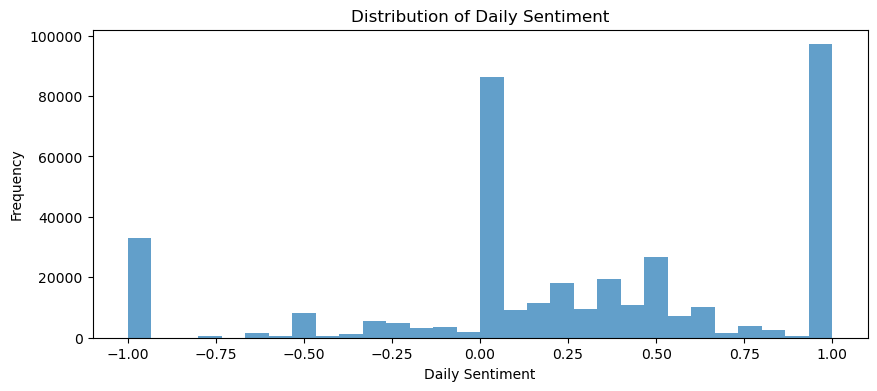

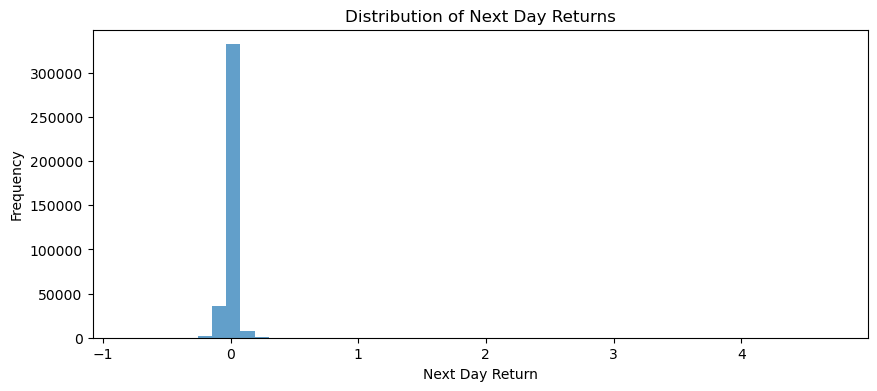

In [20]:
# %% [code]
plt.figure(figsize=(10, 4))
plt.hist(merged_df['Daily_Sentiment'], bins=30, alpha=0.7)
plt.title('Distribution of Daily Sentiment')
plt.xlabel('Daily Sentiment')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 4))
plt.hist(merged_df['Next_Day_Return'], bins=50, alpha=0.7)
plt.title('Distribution of Next Day Returns')
plt.xlabel('Next Day Return')
plt.ylabel('Frequency')
plt.show()


In [21]:
# %% [markdown]
# ## Model Development
#
# We split the training period (2017–2021) into training and validation subsets using a time-based split.
# For demonstration, we use data up to the end of 2020 for training and reserve 2021 for validation.


In [27]:
# %% [code]
# Time-based split: train on dates before 2021, validate on 2021 data
train_df = merged_df[merged_df['Date'].dt.year < 2021].copy()
val_df = merged_df[merged_df['Date'].dt.year == 2021].copy()

# Select features
feature_cols = ['Daily_Sentiment', 'Sentiment_Std', 'Sentiment_Skew', 'Post_Count', 'Log_Post_Count', 
                'Rolling_Avg_3D', 'Rolling_Avg_7D']
X_train = train_df[feature_cols]
y_train = train_df['Next_Day_Return']

X_val = val_df[feature_cols]
y_val = val_df['Next_Day_Return']

# Normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


In [ ]:
# %% [markdown]
# ### Model Training using Ridge Regression
#
# We choose Ridge regression for its simplicity and robustness. We use time-series cross-validation to help avoid overfitting.


In [29]:
# %% [code]
# Define candidate alphas for RidgeCV
# Fill NaN values with 0 in training and validation features
X_train = train_df[feature_cols].fillna(0)
X_val   = val_df[feature_cols].fillna(0)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

alphas = np.logspace(-3, 3, 13)
ridge_model = RidgeCV(alphas=alphas, cv=TimeSeriesSplit(n_splits=5))
ridge_model.fit(X_train_scaled, y_train)

print("Selected alpha:", ridge_model.alpha_)

# Evaluate on validation data
y_val_pred = ridge_model.predict(X_val_scaled)
mse = np.mean((y_val - y_val_pred) ** 2)
mae = np.mean(np.abs(y_val - y_val_pred))
r2 = ridge_model.score(X_val_scaled, y_val)

print(f"Validation Metrics -- MSE: {mse:.6f}, MAE: {mae:.6f}, R²: {r2:.4f}")

# Analyze feature importance (coefficients)
coefficients = pd.Series(ridge_model.coef_, index=feature_cols)
print("Feature Coefficients:")
print(coefficients.sort_values(ascending=False))


Selected alpha: 1000.0
Validation Metrics -- MSE: 0.001863, MAE: 0.023126, R²: -0.0007
Feature Coefficients:
Rolling_Avg_3D     0.000019
Daily_Sentiment    0.000012
Log_Post_Count    -0.000016
Sentiment_Std     -0.000032
Rolling_Avg_7D    -0.000048
Post_Count        -0.000109
Sentiment_Skew    -0.000141
dtype: float64


In [ ]:
# %% [markdown]
# ## Standardized Prediction Function
#
# The following two functions implement the required standardized interface:
#
# 1. **train_model:** Trains a model using the full training dataset (sentiment and return data) and
#    returns a dictionary containing the trained model, scaler, and metadata.
#
# 2. **predict_returns:** Uses the trained model to generate next-day return predictions for all stocks
#    in the day’s trading universe. It accepts the current day’s sentiment data and a list of tickers,
#    and returns a DataFrame with columns: `Ticker`, `Predicted_Return`, and `Signal_Rank`.


In [ ]:
# %% [code]
def train_model(sentiment_data, return_data):
    """
    Train a model using sentiment features to predict next-day returns.
    
    Parameters:
    -----------
    sentiment_data : DataFrame
        The Reddit sentiment data for training (e.g. sentiment_train_2017_2021.csv)
    return_data : DataFrame
        The stock return data for training (e.g. return_train_2017_2021.csv)
        
    Returns:
    --------
    model_info : dict
        Dictionary containing the trained model object and necessary metadata.
    """
    # --- Preprocessing: Convert dates and create effective date if needed ---
    # Ensure Received_Time is a datetime Series
    sentiment_data['Received_Time'] = pd.to_datetime(sentiment_data['Received_Time'])
    # Check if Received_Time is tz-naive (i.e. no timezone info)
    if sentiment_data['Received_Time'].dt.tz is None:
        # If tz-naive, localize it to UTC and then convert to America/New_York
        sentiment_data['Received_Time'] = sentiment_data['Received_Time'].dt.tz_localize('UTC').dt.tz_convert('America/New_York')
    else:
        # If already tz-aware, just convert to America/New_York
        sentiment_data['Received_Time'] = sentiment_data['Received_Time'].dt.tz_convert('America/New_York')

    sentiment_data['Effective_Date'] = sentiment_data['Received_Time'].dt.date
    after_4pm = sentiment_data['Received_Time'].dt.hour >= 16
    sentiment_data.loc[after_4pm, 'Effective_Date'] = sentiment_data.loc[after_4pm, 'Received_Time'].dt.date + pd.Timedelta(days=1)
    sentiment_data['Effective_Date'] = pd.to_datetime(sentiment_data['Effective_Date'])
    
    # --- Feature Engineering ---
    features = create_features(sentiment_data)
    
    # --- Merge with return data ---
    return_data['Date'] = pd.to_datetime(return_data['Date'])
    if return_data['Return'].dtype == object:
        return_data['Return'] = return_data['Return'].str.rstrip('%').astype('float') / 100
    return_data.dropna(inplace=True)
    return_data['Signal_Date'] = return_data['Date'] - pd.Timedelta(days=1)
    
    merged = pd.merge(features, return_data, left_on=['Ticker', 'Effective_Date'], right_on=['Ticker', 'Signal_Date'], how='inner')
    merged.drop(columns=['Signal_Date'], inplace=True)
    merged.rename(columns={'Return': 'Next_Day_Return', 'Effective_Date': 'Date'}, inplace=True)
    merged['Date'].to_datetime()
    
    # --- Split into training and validation subsets ---
    # (For training the final model, you might use all available data; here we mimic a time-based split.)
    train_mask = merged['Date'].dt.year < 2021
    train_df = merged[train_mask].copy()
    
    feature_cols = ['Daily_Sentiment', 'Sentiment_Std', 'Sentiment_Skew', 'Post_Count', 'Log_Post_Count', 
                    'Rolling_Avg_3D', 'Rolling_Avg_7D']
    X = train_df[feature_cols]
    y = train_df['Next_Day_Return']
    
    scaler_local = StandardScaler()
    X_scaled = scaler_local.fit_transform(X)
    
    # --- Model Training using Ridge Regression ---
    alphas = np.logspace(-3, 3, 13)
    model = RidgeCV(alphas=alphas, cv=TimeSeriesSplit(n_splits=5))
    model.fit(X_scaled, y)
    
    # Save metadata necessary for out-of-sample prediction
    model_info = {
        "model": model,
        "scaler": scaler_local,
        "feature_columns": feature_cols,
        "feature_engineering_func": create_features  # If needed for new data
    }
    
    return model_info


In [31]:
# %% [code]
def predict_returns(model, sentiment_data_today, stock_universe_today, historical_data=None):
    """
    Generate predictions of next-day returns for all stocks in the universe.
    
    Parameters:
    -----------
    model : dict
        Dictionary containing your trained model and metadata.
    sentiment_data_today : DataFrame
        Sentiment data for the current day.
    stock_universe_today : list
        List of stock tickers available for trading today.
    historical_data : dict, optional
        Dictionary containing historical sentiment and return data (if required for your model).
    
    Returns:
    --------
    predictions : DataFrame
        DataFrame with columns ['Ticker', 'Predicted_Return', 'Signal_Rank'].
    """
    # Use the same feature engineering function to aggregate today’s data.
    features_today = model["feature_engineering_func"](sentiment_data_today)
    
    # Create a DataFrame with one row per ticker in the universe.
    # Merge the available features with the stock universe so that missing tickers are handled.
    universe_df = pd.DataFrame({'Ticker': stock_universe_today})
    pred_df = pd.merge(universe_df, features_today, on='Ticker', how='left')
    
    # For missing sentiment features, fill with default (e.g., 0).
    feature_cols = model["feature_columns"]
    for col in feature_cols:
        if col not in pred_df.columns:
            pred_df[col] = 0
    pred_df[feature_cols] = pred_df[feature_cols].fillna(0)
    
    # Scale features using the previously fitted scaler.
    X_today = pred_df[feature_cols]
    X_today_scaled = model["scaler"].transform(X_today)
    
    # Predict next-day returns.
    pred_df['Predicted_Return'] = model["model"].predict(X_today_scaled)
    
    # Calculate the percentile rank (signal rank) for each ticker.
    pred_df['Signal_Rank'] = pred_df['Predicted_Return'].rank(pct=True)
    
    # Prepare final output with required columns.
    predictions = pred_df[['Ticker', 'Predicted_Return', 'Signal_Rank']]
    return predictions


In [ ]:
# %% [markdown]
# ## Example Usage
#
# Once you have trained the model using historical data (e.g., 2017-2021), you can generate daily predictions as shown below.


In [40]:
# Reload the returns data to ensure it hasn't been modified inadvertently
returns_df = pd.read_csv('return_train_2017_2021.csv')

# Strip whitespace from column names and standardize case
returns_df.columns = returns_df.columns.str.strip()
returns_df.rename(columns=lambda x: x.title(), inplace=True)  # This converts 'date' to 'Date' if needed
print("Returns DF Columns:", returns_df.columns.tolist())

# Now, call train_model
model_info = train_model(reddit_df, returns_df)


# For demonstration, assume sentiment_data_today is a subset of reddit_df for a recent day
# (In practice, you would use the actual current day data.)
today_date = reddit_df['Effective_Date'].max()
sentiment_today = reddit_df[reddit_df['Effective_Date'] == today_date].copy()

# Assume the stock universe today is the unique tickers from sentiment_today and possibly additional ones.
stock_universe = list(set(sentiment_today['Ticker'].unique()) | set(returns_df['Ticker'].unique()))

# Generate predictions
predictions = predict_returns(model_info, sentiment_today, stock_universe)
print(predictions.head())


Returns DF Columns: ['Date', 'Ticker', 'D0', 'D1', 'Return']


C:\Users\Lukea\AppData\Local\Temp\ipykernel_32280\1528317376.py:22: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'Sentiment': ['mean', 'std', lambda x: stats.skew(x)],


AttributeError: 'DataFrame' object has no attribute 'dt'